# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [2]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt


In [15]:
# Descargar el HTML
url = "https://ycharts.com/companies/TSLA/revenues"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

In [16]:
# Intentar obtener la página varias veces en caso de error
for i in range(5):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        datos_html = response.text
        soup = BeautifulSoup(datos_html, 'html.parser')
        break
    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 403:
            print(f"Request failed with status code {e.response.status_code}. Retrying...")
            headers['User-Agent'] = headers['User-Agent'].replace('Chrome/91.0.4472.124', f'Chrome/{random.randint(50, 60)}.{random.randint(0, 100)}.{random.randint(0, 100)}')
        else:
            raise

In [18]:
# Encontrar todas las tablas en la página
tables = soup.find_all("table")
tables

[<table class="table">
 <thead>
 <tr>
 <th>Date</th>
 <th class="text-right">Value</th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td>June 30, 2024</td>
 <td class="text-right">
                             
                                 25.50B
                             
                         </td>
 </tr>
 <tr>
 <td>March 31, 2024</td>
 <td class="text-right">
                             
                                 21.30B
                             
                         </td>
 </tr>
 <tr>
 <td>December 31, 2023</td>
 <td class="text-right">
                             
                                 25.17B
                             
                         </td>
 </tr>
 <tr>
 <td>September 30, 2023</td>
 <td class="text-right">
                             
                                 23.35B
                             
                         </td>
 </tr>
 <tr>
 <td>June 30, 2023</td>
 <td class="text-right">
                             
                   

In [19]:
# Identificar el índice de la tabla correcta
table_index = None
for index, table in enumerate(tables):
    if "Date" in str(table) and "Value" in str(table):
        table_index = index
        break

if table_index is None:
    raise ValueError("No se encontró la tabla con los datos de ingresos trimestrales.")

In [20]:
# Crear un DataFrame
tesla_revenue = pd.DataFrame(columns=["Date", "Revenue"])
for row in tables[table_index].find_all("tr"):
    cols = row.find_all("td")
    if len(cols) == 2:
        Date = cols[0].text.strip()
        Revenue = cols[1].text.strip().replace("B", "B").replace("M", "M")
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": [Date],
            "Revenue": [Revenue]
        })], ignore_index=True)

# Mostrar las primeras filas del DataFrame
print(tesla_revenue.head())

                 Date Revenue
0       June 30, 2024  25.50B
1      March 31, 2024  21.30B
2   December 31, 2023  25.17B
3  September 30, 2023  23.35B
4       June 30, 2023  24.93B


Limpieza Dataframe

In [21]:
import pandas as pd
import numpy as np

print("DataFrame inicial:")
print(tesla_revenue.head())

# Limpiar los datos
# Eliminar el símbolo "$" y las comas, convertir a valores numéricos
def clean_revenue(value):
    if pd.isna(value) or value.strip() == "":
        return np.nan
    # Remover caracteres no numéricos excepto el punto decimal y la letra 'B' o 'M'
    value = value.replace('B', '').replace('M', '').strip()
    value = value.replace(',', '')
    # Convertir a float, agregando el sufijo 'B' como multiplicador
    if 'B' in value:
        return float(value) * 1e9
    elif 'M' in value:
        return float(value) * 1e6
    else:
        return float(value)

# Aplicar la función de limpieza a la columna 'Revenue'
tesla_revenue['Revenue'] = tesla_revenue['Revenue'].apply(clean_revenue)

# Eliminar filas vacías o con datos no válidos en la columna 'Revenue'
tesla_revenue = tesla_revenue.dropna(subset=['Revenue'])

# Ordenar por fecha (si es necesario) y restablecer el índice
tesla_revenue = tesla_revenue.sort_values(by="Date").reset_index(drop=True)

# Mostrar el DataFrame limpio
print("DataFrame limpio:")
print(tesla_revenue.head())

DataFrame inicial:
                 Date Revenue
0       June 30, 2024  25.50B
1      March 31, 2024  21.30B
2   December 31, 2023  25.17B
3  September 30, 2023  23.35B
4       June 30, 2023  24.93B
DataFrame limpio:
                Date  Revenue
0  December 31, 2018    7.226
1  December 31, 2019    7.384
2  December 31, 2020   10.740
3  December 31, 2021   17.720
4  December 31, 2022   24.320


Almacenar Datos en SQLite

In [22]:
import sqlite3
import pandas as pd

# Crear conexión a la BD SQLite
conn = sqlite3.connect('tesla_revenues.db')

# Crear cursor para ejecutar comandos SQL
cur = conn.cursor()

# Crear la tabla en la BD
cur.execute('''
CREATE TABLE IF NOT EXISTS tesla_revenues (
    Date TEXT PRIMARY KEY,
    Revenue REAL
)
''')

# Comprobar tabla
cur.execute("PRAGMA table_info(tesla_revenues)")
print("Tabla 'tesla_revenues' en la base de datos:")
print(cur.fetchall())

# Insertar datos en la tabla desde el DataFrame
data_to_insert = tesla_revenue.to_records(index=False).tolist()

# Insertar datos en la tabla
cur.executemany('''
INSERT OR REPLACE INTO tesla_revenues (Date, Revenue)
VALUES (?, ?)
''', data_to_insert)

# Confirmar los cambios (commit)
conn.commit()

# Cerrar la conexión
conn.close()

print("Datos almacenados en la base de datos SQLite con éxito.")

Tabla 'tesla_revenues' en la base de datos:
[(0, 'Date', 'TEXT', 0, None, 1), (1, 'Revenue', 'REAL', 0, None, 0)]
Datos almacenados en la base de datos SQLite con éxito.


Visualización de los Datos

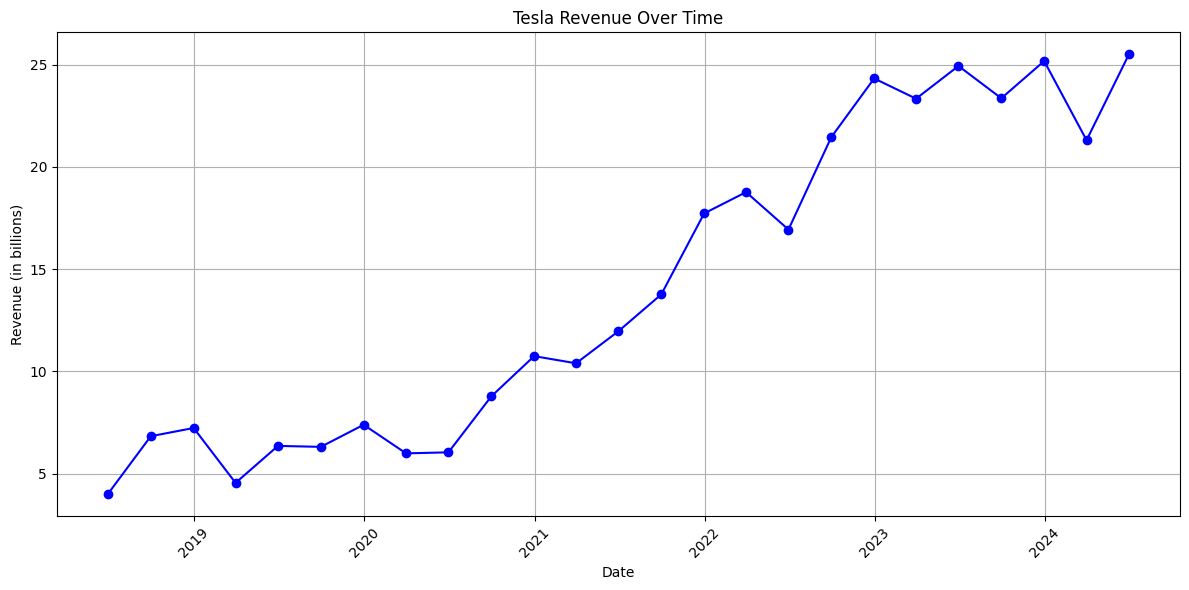

In [24]:
# Grafico 1 de Linea

import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde la BD
conn = sqlite3.connect('tesla_revenues.db')
tesla_revenue = pd.read_sql_query("SELECT * FROM tesla_revenues", conn)
conn.close()

# Convertir la columna 'Date' a tipo datetime y 'Revenue' a tipo numérico
tesla_revenue['Date'] = pd.to_datetime(tesla_revenue['Date'], format='%B %d, %Y')
tesla_revenue['Revenue'] = tesla_revenue['Revenue'].apply(pd.to_numeric, errors='coerce')

# Ordenar los datos por fecha
tesla_revenue = tesla_revenue.sort_values('Date')

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(tesla_revenue['Date'], tesla_revenue['Revenue'], marker='o', linestyle='-', color='b')
plt.title('Tesla Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue (in billions)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

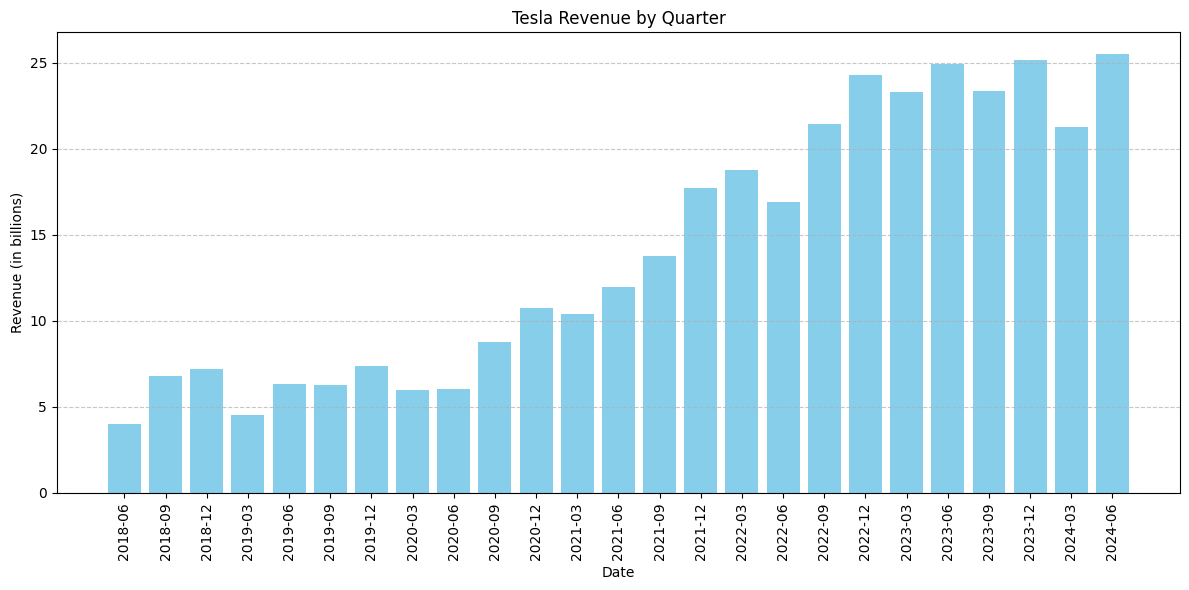

In [25]:
# Grafico 2 Barras
plt.figure(figsize=(12, 6))
plt.bar(tesla_revenue['Date'].dt.strftime('%Y-%m'), tesla_revenue['Revenue'], color='skyblue')
plt.title('Tesla Revenue by Quarter')
plt.xlabel('Date')
plt.ylabel('Revenue (in billions)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

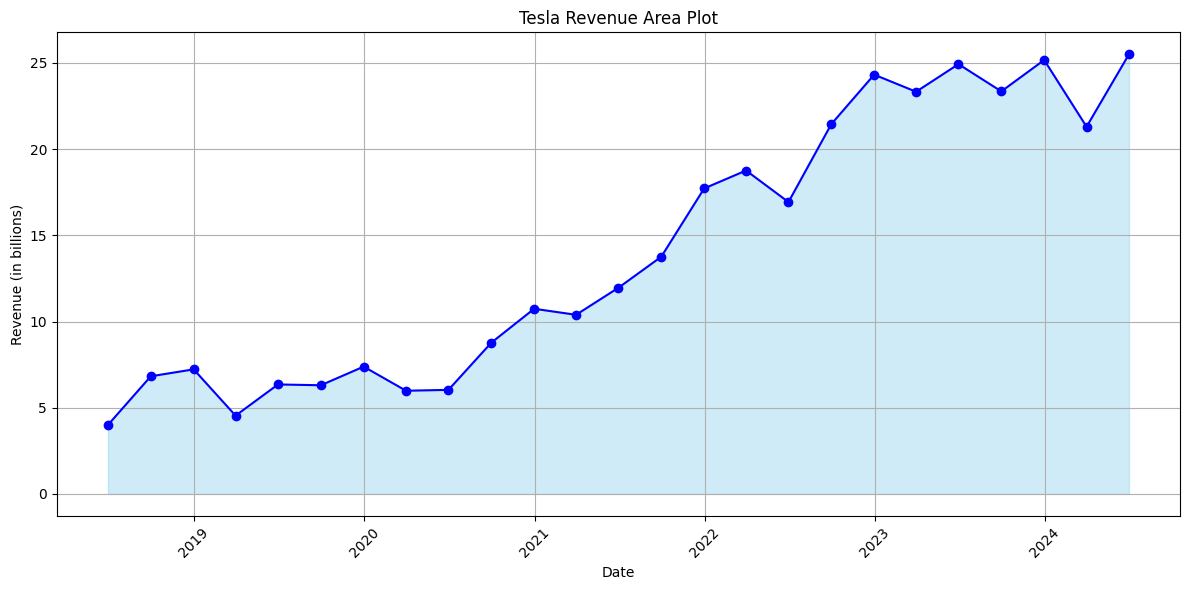

In [26]:
# Grafico 3 de Area
plt.figure(figsize=(12, 6))
plt.fill_between(tesla_revenue['Date'], tesla_revenue['Revenue'], color='skyblue', alpha=0.4)
plt.plot(tesla_revenue['Date'], tesla_revenue['Revenue'], marker='o', color='b', linestyle='-')
plt.title('Tesla Revenue Area Plot')
plt.xlabel('Date')
plt.ylabel('Revenue (in billions)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()